In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from tqdm.auto import trange
from threading import Thread

## Importation of data

Le data provient du repo suivant : https://github.com/chentianyi1991/LAG-code s

In [2]:
data = np.loadtxt("data/data2/data.txt")
data.shape

(351, 34)

In [3]:
y = np.loadtxt("data/data2/y.txt", dtype=int)
y.shape

(351,)

In [4]:
# StandardScaler : mean of 0 and std of 1
scaled_data = StandardScaler().fit_transform(data)

pca = PCA(2)
pca_data = pca.fit_transform(scaled_data)
pca_data.shape

(351, 2)

In [5]:
pca_df = pd.DataFrame(data=pca_data, columns=["PC1", "PC2"])
pca_df["y"] = y
pca_df

,PC1,PC2,y
0,-1.668242,-2.054597,0
1,0.823940,-2.583636,1
2,-2.034095,-0.748245,0
3,1.252374,1.363326,1
4,0.017756,-1.845357,0
...,...,...,...
346,-3.156856,-0.000433,0
347,-3.562330,0.324750,0
348,-3.512043,0.204754,0
349,-3.308935,-0.343454,0


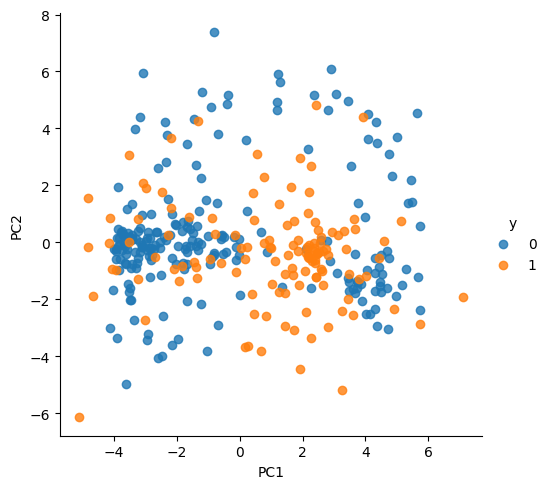

In [6]:
sns.lmplot(x="PC1", y="PC2", data=pca_df, hue="y", fit_reg=False, legend=True)

In [7]:
# Adding an intercept
temp_data = np.ones((data.shape[0], data.shape[1] + 1))
temp_data[:, 1:] = scaled_data
data = temp_data
data.shape

(351, 35)

In [8]:
d = data.shape[1]
d

35

## Logistic Regression

In [9]:
rho = 1

In [10]:
clf = LogisticRegression(
    penalty="l2", C=rho, fit_intercept=False, solver="liblinear"
).fit(data, y)
y_pred = clf.predict(data)
y_pred_proba = clf.predict_proba(data)
clf.score(data, y)  # compute accuracy

0.9259259259259259

In [11]:
opt_theta = clf.coef_
opt_theta

array([[-0.16162871, -2.25989579,  0.        , -0.8004997 ,  0.00761144,
        -0.99946311, -0.9730252 , -0.54479263, -1.07079607, -0.66992926,
        -0.19357204,  0.61352733,  0.18207117,  0.0964342 , -0.3013256 ,
        -0.67571157,  0.42383201, -0.09854566, -0.56972128,  0.80706223,
        -0.01100896, -0.09950051,  1.3649529 , -0.80355806, -0.40487275,
        -0.68251785, -0.18623943,  1.39654551,  0.07158301, -0.53248591,
        -0.93991849, -0.53082438,  0.17228759,  0.37834172,  0.86564326]])

In [12]:
loss = log_loss(y, y_pred_proba, labels=[0, 1])
loss

0.18694318521111666

## GADMM not parallelized

In [13]:
K = 200  # number of iterations
M = 8 # number of workers
rho = 1

split_data = np.array_split(data, M)

In [14]:
len(split_data)

8

In [15]:
split_data[0].shape

(44, 35)

In [16]:
split_y = np.array_split(y, M)

In [17]:
len(split_y)

8

In [18]:
split_y[0].shape

(44,)

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [20]:
def f(theta, sample_data, sample_y):
    proba_pred = [
        sigmoid(np.inner(theta, sample_data[i])) for i in range(len(sample_y))
    ]
    # y_pred = [int(proba>0.5) for proba in proba_pred]

    return log_loss(sample_y, proba_pred, labels=[0, 1])

In [21]:
f(opt_theta, data, y)

0.18694318521111672

On a la même loss qu'avec sklearn, tout va bien !

---



In [22]:
def objective_function(
    theta_n,
    sample_data,
    sample_y,
    lamb_n,
    lamb_n_minus_1,
    theta_n_minus_1,
    theta_n_plus_1,
    rho,
):
    resul = f(theta_n, sample_data, sample_y)
    if theta_n_minus_1 is not None:
        resul += lamb_n_minus_1 @ (theta_n_minus_1 - theta_n)
        resul += (rho / 2) * ((theta_n_minus_1 - theta_n) ** 2).sum()
    if theta_n_plus_1 is not None:
        resul += lamb_n @ (theta_n - theta_n_plus_1)
        resul += (rho / 2) * ((theta_n - theta_n_plus_1) ** 2).sum()

    return resul

In [23]:
# Initialisation
Theta = np.zeros((M, d))
Lamb = np.zeros((M, d))

# Iterative procedure
df_log = []

for k in trange(K):
    # Step 1 : head workers
    for n in range(M):
        if n % 2 == 0:
            sample_data = split_data[n]
            sample_y = split_y[n]
            lamb_n = Lamb[n]
            lamb_n_minus_1 = Lamb[n - 1] if n > 0 else None
            theta_n_minus_1 = Theta[n - 1] if n > 0 else None
            theta_n_plus_1 = Theta[n + 1] if n < M else None
            res = minimize(
                objective_function,
                x0=Theta[n],
                args=(
                    sample_data,
                    sample_y,
                    lamb_n,
                    lamb_n_minus_1,
                    theta_n_minus_1,
                    theta_n_plus_1,
                    rho,
                ),
            )
            Theta[n] = res.x

    # Step 2 : tail workers
    for n in range(M):
        if n % 2 == 1:
            sample_data = split_data[n]
            sample_y = split_y[n]
            lamb_n = Lamb[n]
            lamb_n_minus_1 = Lamb[n - 1] if n > 0 else None
            theta_n_minus_1 = Theta[n - 1] if n > 0 else None
            theta_n_plus_1 = Theta[n + 1] if n < M - 1 else None
            res = minimize(
                objective_function,
                x0=Theta[n],
                args=(
                    sample_data,
                    sample_y,
                    lamb_n,
                    lamb_n_minus_1,
                    theta_n_minus_1,
                    theta_n_plus_1,
                    rho,
                ),
            )
            Theta[n] = res.x

    # Step 3 : Update lambda
    for n in range(M - 1):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - Theta[n + 1])

    for n in range(M):
        df_log.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log)

  0%|          | 0/200 [00:00<?, ?it/s]

In [24]:
Theta[0]

array([-8.49208176e-02, -2.63678721e+00, -2.98952650e-06, -9.07138820e-01,
        2.65724272e-02, -1.15844688e+00, -1.11985831e+00, -6.28078588e-01,
       -1.25819397e+00, -6.46488371e-01, -2.23246296e-01,  7.05643973e-01,
        2.54686657e-01,  1.29020213e-01, -3.29426330e-01, -7.23213295e-01,
        5.16161586e-01, -1.06634217e-01, -6.57783913e-01,  7.86740563e-01,
        8.46509275e-03, -1.31955130e-01,  1.55391826e+00, -8.57038966e-01,
       -4.71885995e-01, -7.77226394e-01, -2.42114458e-01,  1.59096525e+00,
        7.85494968e-02, -5.95630008e-01, -1.10029232e+00, -6.43052432e-01,
        1.88974107e-01,  4.92852689e-01,  1.02459070e+00])

In [25]:
def display_df_log(df_log):
    sns.lineplot(x="iteration", y="theta diff norm", data=df_log, hue="worker")
    plt.grid()
    plt.show()

    sns.lineplot(x="iteration", y="loss", data=df_log, hue="worker")
    plt.grid()
    plt.show()

    df_data = []
    for n in range(M):
        df_data.append(
            {
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )
    display(pd.DataFrame(df_data))

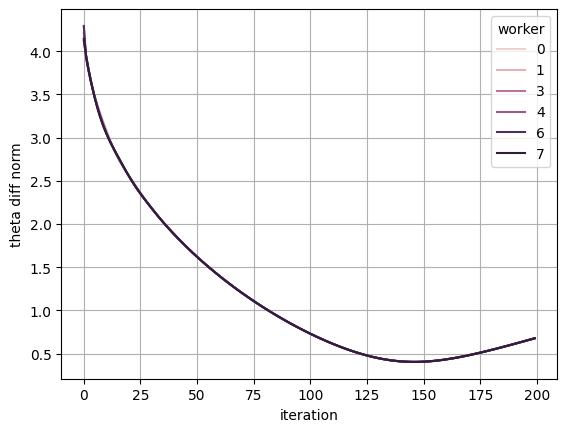

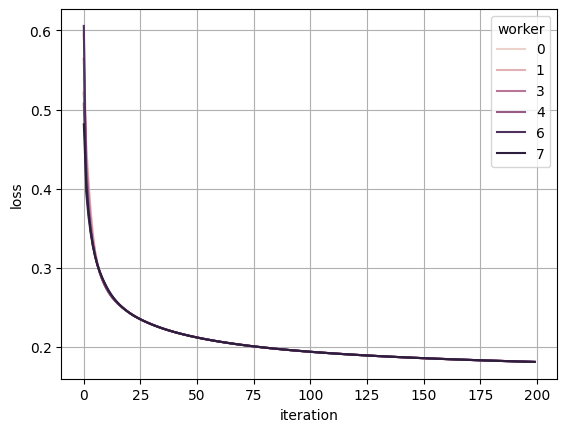

,worker,theta diff norm,loss
0,0,0.678230,0.180940
1,1,0.678222,0.180940
2,2,0.678249,0.180940
3,3,0.678234,0.180940
4,4,0.678257,0.180940
5,5,0.678243,0.180940
6,6,0.678265,0.180939
7,7,0.678236,0.180939


In [26]:
display_df_log(df_log)

In [27]:
# Multithreading

def thread_func_head(sample_data, sample_y, Lamb, Theta, n):
    lamb_n = Lamb[n]
    lamb_n_minus_1 = Lamb[n - 1] if n > 0 else None
    theta_n_minus_1 = Theta[n - 1] if n > 0 else None
    theta_n_plus_1 = Theta[n + 1] if n < M else None
    res = minimize(
        objective_function,
        x0=Theta[n],
        args=(
            sample_data,
            sample_y,
            lamb_n,
            lamb_n_minus_1,
            theta_n_minus_1,
            theta_n_plus_1,
            rho,
        ),
    )
    Theta[n] = res.x


def thread_func_tail(sample_data, sample_y, Lamb, Theta, n):
    lamb_n = Lamb[n]
    lamb_n_minus_1 = Lamb[n - 1] if n > 0 else None
    theta_n_minus_1 = Theta[n - 1] if n > 0 else None
    theta_n_plus_1 = Theta[n + 1] if n < M - 1 else None
    res = minimize(
        objective_function,
        x0=Theta[n],
        args=(
            sample_data,
            sample_y,
            lamb_n,
            lamb_n_minus_1,
            theta_n_minus_1,
            theta_n_plus_1,
            rho,
        ),
    )
    Theta[n] = res.x

In [28]:
# Initialisation
Theta = np.zeros((M, d))
Lamb = np.zeros((M, d))

# Iterative procedure
df_log = []

for k in trange(K):
    # Step 1 : head workers
    threads = []
    for n in range(M):
        if n % 2 == 0:
            thread = Thread(target=thread_func_head, args=(split_data[n], split_y[n], Lamb, Theta, n))
            threads.append(thread)
            thread.start()

    for thread in threads:
        thread.join()

    # Step 2 : tail workers
    threads = []
    for n in range(M):
        if n % 2 == 1:
            thread = Thread(target=thread_func_tail, args=(split_data[n], split_y[n], Lamb, Theta, n))
            threads.append(thread)
            thread.start()

    for thread in threads:
        thread.join()

    # Step 3 : Update lambda
    for n in range(M - 1):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - Theta[n + 1])

    for n in range(M):
        df_log.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log)

  0%|          | 0/200 [00:00<?, ?it/s]

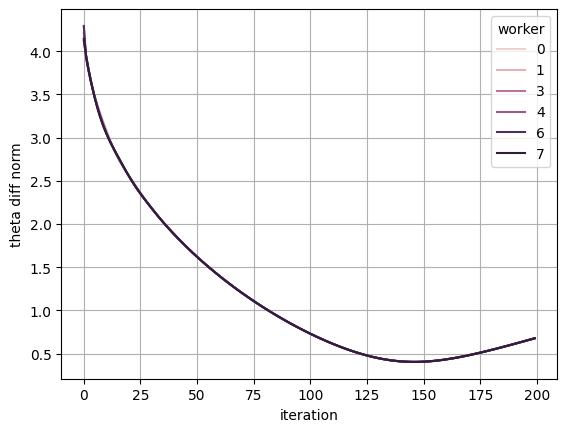

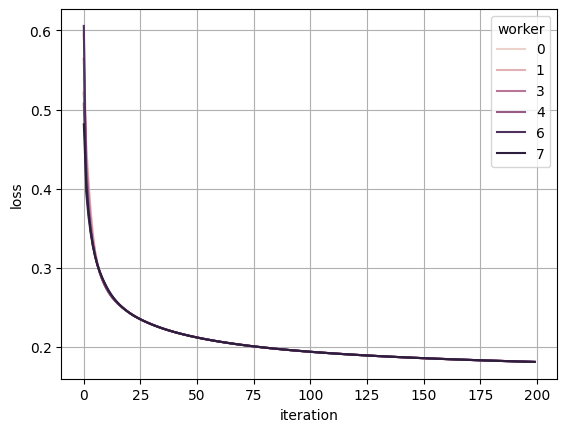

,worker,theta diff norm,loss
0,0,0.678230,0.180940
1,1,0.678222,0.180940
2,2,0.678249,0.180940
3,3,0.678234,0.180940
4,4,0.678257,0.180940
5,5,0.678243,0.180940
6,6,0.678265,0.180939
7,7,0.678236,0.180939


In [29]:
display_df_log(df_log)